In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
from sklearn.model_selection import train_test_split
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer

from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN


In [2]:
j_coupling = 1 #coupling constant J
h_coupling = 3 #coupling constant h

In [85]:
num_qubits=5

In [86]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
ansatz = RealAmplitudes(num_qubits=num_qubits,reps=5)
qc.h(qr)
qc.compose(ansatz, inplace=True)  
observable_list=[]
observable1 = SparsePauliOp.from_list([("X"*num_qubits , h_coupling )])
observable_list.append(observable1)

for i in range(num_qubits-1):
    ob=SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(num_qubits-2-i) , j_coupling)])
    observable_list.append(ob)
    

In [87]:
observable_list

[SparsePauliOp(['XXXXX'],
               coeffs=[3.+0.j]),
 SparsePauliOp(['ZZIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZZII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIZZ'],
               coeffs=[1.+0.j])]

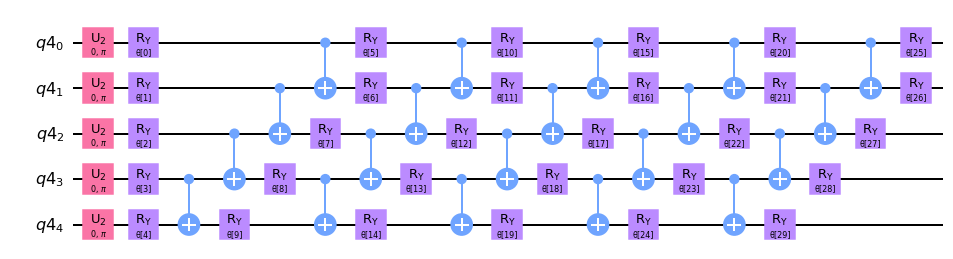

In [88]:
qc.decompose().draw('mpl')

In [89]:
qnn_list=[]
for i in range(num_qubits):
    qnn_list.append(EstimatorQNN(
    circuit=qc,
    weight_params=ansatz.parameters,
    observables=observable_list[i]
))

In [90]:
init_weights=np.random.rand(ansatz.num_parameters)*2*np.pi
#init_weights=np.zeros(ansatz.num_parameters)
weights=init_weights

In [91]:
# cost_list=[]
# gradMag_list=[]
# for i in range(100):
#     if i%10==0:
#         print(i)
#     weights=np.random.rand(ansatz.num_parameters)*2*np.pi

#     vev=0
#     grad=np.zeros(weights.shape[0])
    
#     for qnn in qnn_list:
#         vev+=qnn.forward([], weights)[0][0]
#         input_grad, weight_grad=qnn.backward([],weights)
#         grad+=weight_grad[0,0,:]
        
#     cost_list.append(vev**2)
#     gradMag_list.append(computeMag(grad)**2)
# cost_list=np.array(cost_list)
# gradMag_list=np.array(gradMag_list)

In [92]:
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x)
    plt.show()

In [93]:
def computeMag(x):
    x2=x**2
    return x2.sum()

In [94]:
def getGradient_pShift(qnn,weights):
    grad=[]
    for i in range(len(weights)):
        weights_plus=weights.copy()
        weights_plus[i]+=np.pi/2
        weights_minus=weights.copy()
        weights_minus[i]-=np.pi/2
        plus=qnn.forward([],weights_plus)
        minus=qnn.forward([],weights_minus)
        grad.append(0.5*(plus-minus))
    return np.array(grad)[:,0,0]

def getHessian_pShift(qnn,weights):
    grad=[]
    for i in range(len(weights)):
        for j in range(len(weights)):
            tmpWeights=np.array([weights.copy()]*4)
            tmpWeights[0][i]+=np.pi/2
            tmpWeights[0][j]+=np.pi/2
            
            tmpWeights[1][i]-=np.pi/2
            tmpWeights[1][j]+=np.pi/2
            
            tmpWeights[2][i]+=np.pi/2
            tmpWeights[2][j]-=np.pi/2
        
            tmpWeights[3][i]-=np.pi/2
            tmpWeights[3][j]-=np.pi/2
            
            plusPlus=qnn.forward([],tmpWeights[0])
            minusPlus=qnn.forward([],tmpWeights[1])
            plusMinus=qnn.forward([],tmpWeights[2])
            minusMinus=qnn.forward([],tmpWeights[3])
                
            grad.append(0.25*(plusPlus+minusMinus-minusPlus-plusMinus))
    return np.array(grad)[:,0,0].reshape(len(weights),len(weights))
        

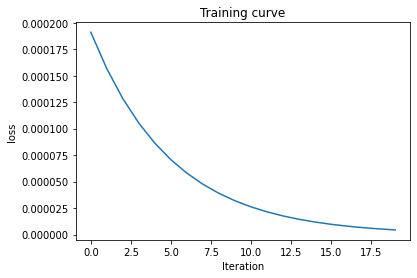

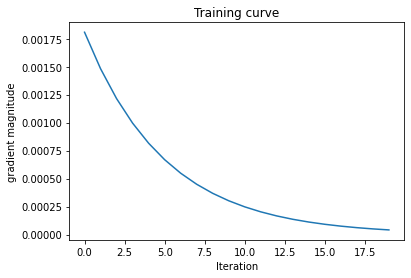

In [95]:
nSteps=20
learning_rate=1e-2
loss=[]
gradMag=[]
for i in range(nSteps):
    if i%2==0:
        print(i)
        
    #for i in range(len(qnn_list)):
    vev=0
    grad=np.zeros(weights.shape[0])
    for qnn in qnn_list:
        
        vev+=qnn.forward([], weights)[0][0]
        input_grad, weight_grad=qnn.backward([],weights)
        grad+=weight_grad[0,0,:]
        
    grad=vev*grad
    #print(grad)
    weights=weights-learning_rate*grad

    loss.append(vev**2)
    gradMag.append(computeMag(grad))
    clear_output(wait=True)
    plt.figure(1)
    callback_graph(loss)
    plt.figure(2)
    callback_graph(gradMag,"gradient magnitude")

In [96]:
grad=getGradient_pShift(qnn,weights)

In [97]:
t1=time.time()
hess=getHessian_pShift(qnn,weights)
print(time.time()-t1)

7.585944890975952


In [98]:
np.matmul(hess,grad)

array([ 2.26976956e-02,  7.98296515e-02, -2.41653077e-01,  1.14380382e-01,
       -6.55490741e-02, -5.30891705e-02,  1.11855964e-01,  1.01672011e-01,
        1.06145292e-01, -5.75737590e-02, -4.22230909e-02, -7.69093082e-02,
        9.41801162e-02,  2.89921102e-01, -5.97123843e-02, -1.67983385e-02,
       -2.87852993e-02,  5.97726885e-02,  1.74873221e-02, -5.85647555e-02,
       -1.34032088e-02,  8.43976084e-02, -1.03725949e-01, -4.92180537e-02,
        1.44494559e-01,  1.28637964e-01,  1.15581936e-01,  7.68151771e-18,
       -2.32482073e-17, -8.78116903e-18])